# Question 7

# Set-up setction

## import modules

In [55]:
import tensorflow as tf
from datetime import datetime
import os
import time
import sklearn
from functools import partial

In [56]:
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## Loading data

In [57]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [58]:
X_train = mnist.train.images.reshape(-1,28,28,1)
y_train = mnist.train.labels
X_test = mnist.test.images.reshape(-1,28,28,1)
y_test = mnist.test.labels
X_valid = mnist.validation.images.reshape(-1,28,28,1)
y_valid = mnist.validation.labels

## Batch function

In [59]:
def get_mini_batch(X, y, batch_size, epoch, batch):
    """
    get a batch of training set
    """
    num_inst = X.shape[0]
    np.random.seed(epoch * batch * np.random.randint(100))
    shuffle_index = np.random.randint(num_inst, size=batch_size)
    return X[shuffle_index], y[shuffle_index]

# Constructing CNN

### Reset function

In [60]:
graph=None

In [61]:
def reset_graph(graph=None, random=42):
    try:
        del graph
    except NameError:
        pass
    np.random.seed(random)
    tf.set_random_seed(random)
    graph = tf.Graph()

    return graph

## Construct CNN

#### Setting constants for network

In [62]:
base_dir = 'temp'
base_dir_saves = os.path.join(base_dir, "saves")
base_dir_logs = os.path.join(base_dir, "logs")

random_seed = 42

n_outputs = np.unique(y_train).shape[0]

learning_rate=0.005

#### Reset graph

In [63]:
graph = reset_graph(graph, random_seed)

### Make network part

In [64]:
dropout_rate = 0.5

In [66]:
with graph.as_default():
    with tf.name_scope("inputs"):
        X = inputs = tf.placeholder(tf.float32, 
                                    shape=[None, 28, 28, 1], name="X")
        y = tf.placeholder(
                        tf.int32,
                        name="y")
        
        training = tf.placeholder_with_default(False, [], name="training")
    
    conv1 = tf.layers.conv2d(
                            inputs,
                            filters=6,
                            kernel_size=3,
                            strides=(1, 1),
                            padding='SAME',
                            activation=tf.nn.selu,
                            name="conv1",
                        )

    conv2 = tf.layers.conv2d(
                            conv1,
                            filters=12,
                            kernel_size=3,
                            strides=(1, 1),
                            padding='SAME',
                            activation=tf.nn.selu,
                            name="conv2",
                        )

    max_pool3 = tf.layers.max_pooling2d(
                                conv2,
                                pool_size=8,
                                strides=2,
                                padding='SAME',
                                name="max_pool3"
                            )
    with tf.name_scope("conv4"):
        conv4 = tf.layers.conv2d(
                                max_pool3,
                                filters=12,
                                kernel_size=3,
                                strides=(1, 1),
                                padding='SAME',
                                activation=tf.nn.selu,
                                name="conv4",
                            )

        num_ele = int(conv4.shape[1]*conv4.shape[2]*conv4.shape[3])
        conv4_flat = tf.reshape(
                            conv4,
                            shape=[-1, num_ele],
                            name="conv4_flat"
                          )
        conv4_flat_dropout = tf.layers.dropout(conv4_flat, rate=dropout_rate,
                                            training=training,
                                            name="conv4_flat_dropout")
        
    with tf.name_scope("fc5"):
        fc5 = tf.layers.dense(
                                conv4_flat_dropout,
                                conv4_flat_dropout.shape[1]//2,
                                activation=tf.nn.selu,
                                name="fc5",
                            )
        fc5_dropout = tf.layers.dropout(fc5, rate=dropout_rate,
                                       training=training,
                                       name="fc5_dropout")

    logits = tf.layers.dense(
                            fc5_dropout,
                            n_outputs,
                            name="logits",
                        )
        
    with tf.name_scope("outputs"):
        y_prob = tf.nn.softmax(logits, 
                               axis=1,
                               name="y_prob")
        
        y_pred = tf.cast(tf.argmax(
                                logits,
                                axis=1,
                                ), 
                         tf.int32,
                         name="y_pred")
        
    with tf.name_scope("train"):
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
                                                        labels=y, 
                                                        logits=logits,
                                                        name="xentropy"
                                                     )
        loss = tf.reduce_mean(
                            xentropy,
                            name='loss'
                        )

        training_op = tf.train.AdamOptimizer(
                                            learning_rate=learning_rate, 
                                            beta1=0.9,
                                            beta2=0.999,
                                            epsilon=1e-08,
                                            name="Adam")\
                                            .minimize(
                                                    loss,
                                                    name="training_op")

### Auxiliary network part

In [67]:
with graph.as_default():
    with tf.name_scope("eval"):
        correct = tf.cast(tf.equal(
                                y,
                                y_pred,),
                         tf.float32,
                         name="correct")
        accuracy = tf.reduce_mean(correct, name="accuracy")
        
    with tf.name_scope("saver"):
        saver = tf.train.Saver(name="saver")
        
        
    str_time_now = datetime.now().strftime("%Y%m%d%H%M%S")
    dir_logs = os.path.join(base_dir_logs, str_time_now)
    with tf.name_scope("logging"):
        file_writer = tf.summary.FileWriter(dir_logs)
        log_training_acc = tf.summary.scalar("training_accuracy", accuracy)
        log_valid_acc = tf.summary.scalar("validation_accuracy", accuracy)
        log_training_loss = tf.summary.scalar("training_loss", loss)
        log_valid_loss = tf.summary.scalar("validatiaon_loss", loss)
        
    with tf.name_scope("initializer"):
        initializer = tf.global_variables_initializer()

### Adding collection

In [68]:
graph.add_to_collection("input_ops", X)
graph.add_to_collection("input_ops", y)
graph.add_to_collection("output_ops", logits)
graph.add_to_collection("output_ops", y_prob)
graph.add_to_collection("output_ops", y_pred)
graph.add_to_collection("metrics_ops", loss)
graph.add_to_collection("metrics_ops", correct)
graph.add_to_collection("metrics_ops", accuracy)
graph.add_to_collection("training_ops", training_op)

## Train network

#### Setting some constant

In [69]:
small_index = np.random.permutation(X_train.shape[0])[:2000]
X_train_small = X_train[small_index]
y_train_small = y_train[small_index]

train_size=X_train.shape[0]
# train_size=X_train_small.shape[0]
test_size = X_test.shape[0]
valid_size = X_valid.shape[0]

n_epochs = 20
batch_size = 100
n_batchs = (np.ceil(train_size/batch_size) + 1).astype(int)

log_freq = 1
max_drop = 10

dir_saves = os.path.join(base_dir_saves, str_time_now)

if not os.path.isdir(dir_saves):
    print("Making path of saving dirs")
    
    os.makedirs(dir_saves)
    
if not os.path.isdir(dir_logs):
    print("Making path of logging dirs")
    os.makedirs(dir_logs)

Making path of saving dirs


In [70]:
with graph.as_default():
    with tf.Session() as sess:
        with open(os.path.join(dir_saves, 'record.txt'), 'a') as hfile:
            cdrop = 0
            max_valid_acc = 0

            initializer.run()
            file_writer.add_graph(graph)
            for epoch in range(n_epochs):
                for batch in range(n_batchs):
                    X_batch, y_batch = get_mini_batch(X_train, 
                                                      y_train, 
                                                      batch_size, 
                                                      epoch, 
                                                      batch)
                    sess.run(training_op,
                            feed_dict={X:X_batch,
                                       y:y_batch,}
                            )
                if not epoch % log_freq:
                    val_training_acc,\
                    val_training_loss,\
                    str_training_acc,\
                    str_training_loss=\
                    sess.run([accuracy, 
                              loss,
                              log_training_acc, 
                              log_training_loss],
                              feed_dict={X:X_train,
                                         y:y_train})

                    val_validation_acc,\
                    val_validation_loss,\
                    str_validation_acc,\
                    str_validation_loss=\
                    sess.run([accuracy, 
                              loss,
                              log_valid_acc,
                              log_valid_loss],
                              feed_dict={X:X_valid,
                                         y:y_valid})
                    rec_train_loss = "%2d train loss:%.4f\n" % (epoch, val_training_loss)
                    rec_train_acc = "    train acc:%4f\n" % val_training_acc
                    rec_validation_loss = "                     validation loss:%.4f\n" % val_validation_loss
                    rec_validation_acc = "                      validation acc:%.4f\n" % val_validation_acc
                    print(rec_train_loss, end='')
                    print(rec_train_acc, end='')
                    print(rec_validation_loss, end='')
                    print(rec_validation_acc, end='')
                    
                    hfile.write(rec_train_loss+rec_train_acc+
                                rec_validation_loss+rec_validation_acc+'\n')
                    hfile.flush()
                    
                    


    #                 correct_label= sess.run(correct,
    #                               feed_dict={X:X_valid,
    #                                          y:y_valid})

                    file_writer.add_summary(str_training_acc, 
                                            epoch*n_batchs+batch)
                    file_writer.add_summary(str_training_loss,
                                            epoch*n_batchs+batch)
                    file_writer.add_summary(str_validation_acc,
                                            epoch*n_batchs+batch)
                    file_writer.add_summary(str_validation_loss,
                                            epoch*n_batchs+batch)

                    save_path = saver.save(sess, os.path.join(dir_saves, 
                                                              '{}.ckpt'
                                                              .format(epoch)))

                    if val_validation_acc > max_valid_acc:
                        cdrop = 0
                        max_valid_acc = val_validation_acc
                        best_save_path = save_path

                    else:
                        cdrop += 1

                    if cdrop >= max_drop:
                        print("cdrop:%d  Early stopping" % cdrop)
                        break

            final_save_path = saver.save(sess, dir_saves)
            
            hfile.write('Best save path: %s' % best_save_path)
            hfile.write('Final save path: %s\n' % final_save_path)
            hfile.flush()


 0 train loss:1.8484
    train acc:0.751745
                     validation loss:1.7019
                      validation acc:0.7656
 1 train loss:0.0745
    train acc:0.978927
                     validation loss:0.0782
                      validation acc:0.9764
 2 train loss:0.0958
    train acc:0.972818
                     validation loss:0.1072
                      validation acc:0.9706
 3 train loss:0.1186
    train acc:0.971727
                     validation loss:0.1292
                      validation acc:0.9714
 4 train loss:0.1397
    train acc:0.969836
                     validation loss:0.1422
                      validation acc:0.9738
 5 train loss:0.8394
    train acc:0.939564
                     validation loss:0.8237
                      validation acc:0.9470
 6 train loss:0.3108
    train acc:0.979182
                     validation loss:0.3345
                      validation acc:0.9786
 7 train loss:0.6576
    train acc:0.967382
                     validation 

In [73]:
best_save_path = final_save_path

In [74]:
with graph.as_default():
    with tf.Session() as sess:
        saver.restore(sess, best_save_path)
        test_pred, test_prob, test_acc, test_loss, test_entropy = \
            sess.run([y_pred, y_prob, accuracy, loss, xentropy],
                    feed_dict={X: X_test, y: y_test})
        print("test accuracy = {}, test loss = {}, test entropy = {}"
              .format(test_acc, test_loss, test_entropy))

INFO:tensorflow:Restoring parameters from temp/saves/20180223001339
test accuracy = 0.987500011920929, test loss = 0.6853736639022827, test entropy = [0. 0. 0. ... 0. 0. 0.]


[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


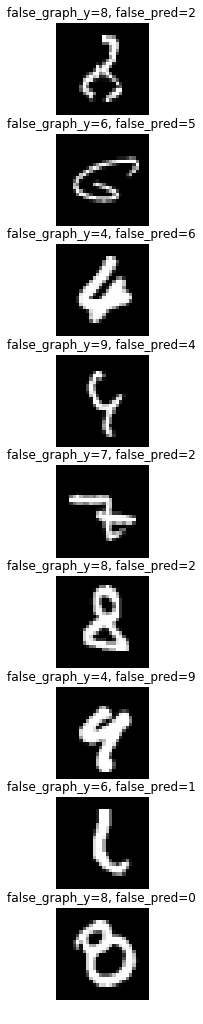

In [85]:
false_ind = (test_entropy > 1e+2)
false_graph_X = X_test[false_ind]
false_graph_y = y_test[false_ind]
false_prob = test_prob[false_ind]
false_pred = test_pred[false_ind]

from matplotlib import gridspec

plt.figure(figsize = (20,20))
for i in range(1, min(len(false_graph_X), 10)):
    ax = plt.subplot(min(len(false_graph_X), 10), 1, i)
    ax.set_title("false_graph_y={}, false_pred={}".format(false_graph_y[i], false_pred[i]))
    ax.axis("off")
    false_img = false_graph_X[i].reshape(28, 28)
    plt.imshow(false_img, cmap="gist_gray", interpolation='nearest')
    print(false_prob[i])

## Load model

Missing lines ^.^